In [2]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.preprocessing import MinMaxScaler

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-07-11 16:08:03.243795: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-11 16:08:03.289461: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 16:08:03.289500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 16:08:03.289533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has a

In [3]:
from configure import configure_tensorflow
configure_tensorflow(gpu_index=1, allow_growth_gpu=True)

--------------------------------------------------------------------------------
TensorFlow version: 2.14.0
Device information:
    0 physical GPU(s) available
    0 logical GPU(s) available
Debugging information:
    Eager execution enabled for functions: False
    Experimental debugging mode enabled for TensorFlow Dataset API: False
--------------------------------------------------------------------------------


/home/nkriss/notebooks/Noah_Tests/configure.py:43: RuntimeWarning: No GPUs detected.
  warnings.warn("No GPUs detected.", RuntimeWarning)


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
#Function to produce training and targets using full dataset tables

def produceXYDataSets(tickers, corp, ns_back): 
    print("Loading:")
    
    x_data = []
    x_stockdata = []
    y_train = []
    ticker_counter = 1
    
    for ticker in tickers:
        
        print(ticker)
    
        df = pd.read_csv('../../data/finance/optionchaindata/all/'+ticker+'_alldata_'+corp+'.csv.zip', parse_dates=['quoteDate','expiryDate'])
        #print("Dataframe shape from file",df.shape)

        #basic data cleaning, remove lines where the strike price is more than 50 from the stockprice
        df_good = df[ df['strikeDelta'] > -50 ]
        #print("After removing deltastrike bigger than -50", df_good.shape)

        df_good = df_good[ df_good['strikeDelta'] < 50 ]
        #print("After removing deltastrike less than 50", df_good.shape)

        #All contract names to read through
        contracts = df_good['contractSymbol'].unique()

        #Only look at contracts that have at least 1.5 time as many entries as the look back time
        nquotes_min = int(1.5*ns_back)
        good_contracts = []

        for contract in contracts:
            data = df_good[df_good['contractSymbol'] == contract]

            if data.shape[0] < nquotes_min:
                continue

            good_contracts.append(contract)

            #data['deltaDays'] = data['quoteDate'].diff()
            #data['weekday'] = data['quoteDate'].dt.dayofweek

            # make sure to load the time data as a TIME then do the math

            ndays = data.shape[0]

            for iday in range(ns_back+1, ndays):
                
                #Y:
                ask = data['ask'].values[iday]
                bid = data['bid'].values[iday]
                
                stockPrices = data['stockClose'][iday-ns_back-1:iday-1].values
                askPrices = data['ask'][iday-ns_back-1:iday-1].values
                bidPrices = data['bid'][iday-ns_back-1:iday-1].values
                optionPrices = (askPrices + bidPrices)/2
                
                smallest_bidask = 1
                
                if bid > smallest_bidask and ask > smallest_bidask and np.max(stockPrices) > 0 and np.max(optionPrices) > 0 and np.min(stockPrices) != np.max(stockPrices) and np.min(optionPrices) != np.max(optionPrices): # and np.max(askPrices) > 0 and np.max(bidPrices) > 0:
                
                    #X:
                    
                    strike = data['strike'].values[iday]
                    openInterest = data['openInterest'].values[iday]
                    daysToExpiry = int(data['daysToExpiry'].values[iday].split('days')[0])
                    impliedVolatility = data['impliedVolatility'].values[iday]
                    lastPrice = data['lastPrice'].values[iday]

                    norm_stockPrices = (stockPrices - np.min(stockPrices)) / (np.max(stockPrices) - np.min(stockPrices))
                    norm_optionPrices = (optionPrices - np.min(optionPrices)) / (np.max(optionPrices) - np.min(optionPrices))
                
                    odata = [strike, openInterest, impliedVolatility, daysToExpiry, data['stockClose'].values[iday], ticker_counter]
                    stockdata = np.stack((norm_stockPrices, norm_optionPrices))
                    # stockdata = norm_stockPrices
                    
                    targets = np.array([bid, ask])

                    x_data.append(odata)
                    x_stockdata.append(stockdata)
                    y_train.append(targets)
                    
        ticker_counter += 1
    
    
    x_data_up = np.array(x_data)
    x_stockdata_up = np.array(x_stockdata)
    y_train_up = np.array(y_train)
    
    slices_to_remove_2d = np.isnan(x_data_up).any(axis=1)
    slices_to_remove_3d = np.isnan(x_stockdata_up).any(axis=(1, 2))
    slices_to_remove = slices_to_remove_2d | slices_to_remove_3d
    print(np.sum(slices_to_remove))
    x_data_up = x_data_up[~slices_to_remove, :]
    x_stockdata_up = x_stockdata_up[~slices_to_remove, :, :]
    
    min_scale = np.min(x_data_up)
    max_scale = np.max(x_data_up)
    
    # x_data_up = (x_data_up - min_scale) / (max_scale - min_scale)


      
    return x_data_up, x_stockdata_up, y_train_up



cad_tickers = ['CGC','CM','RY','BNS','BMO','BAM','SHOP','CP','CNI','MO','ENB','MFC','GOLD','TU','SLF','IMO','RCI','SU','CNQ']

us_tickers = ['HSBC','GLD','AAPL','MSFT','TSLA','AMZN', 'NVDA','BAC', 'PG', 'HD', 'MA', 'PFE', 'MRK','INTC', 'UPS', 'NFLX', 'RTX','AMD','CVS','PYPL','UL','C','RIO','BA','GS','CAT','GSK','BP','SHEL','VALE']

all_tickers = us_tickers + cad_tickers


In [6]:
stockdata_len = 10

use_tickers = ['CGC','CM','RY','BNS','BMO','BAM','SHOP','CP','CNI','MFC','TU','SLF','RCI']
test_tickers = ['GOOGL', 'TD']

[x_data_up, x_stockdata_up, y_train_up] = produceXYDataSets(use_tickers, "C", stockdata_len)
print("[x_data_up, x_stockdata_up, y_train_up] shape:", x_data_up.shape, x_stockdata_up.shape, y_train_up.shape)

Loading:
CGC
CM
RY
BNS
BMO
BAM
SHOP
CP
CNI
MFC
TU
SLF
RCI
0
[x_data_up, x_stockdata_up, y_train_up] shape: (89850, 6) (89850, 2, 10) (89850, 2)


In [7]:
# average bid and ask
y_train_avg = (y_train_up[:,0]+y_train_up[:,1])/2

indices = np.arange(x_data_up.shape[0])
np.random.shuffle(indices)

# Step 2: Reorder the datasets using the shuffled indices
x_data_shuffled = x_data_up[indices]
x_stockdata_shuffled = x_stockdata_up[indices]
y_train_avg_shuffled = y_train_avg[indices]

# Step 3: Split the data
x_data_p, x_data_test, y_train, y_test = train_test_split(x_data_shuffled, y_train_avg_shuffled, test_size=0.2, shuffle=False)
x_stockdata_p, x_stockdata_test, y_train_na, y_test_na = train_test_split(x_stockdata_shuffled, y_train_avg_shuffled, test_size=0.2, shuffle=False)

x_data_p = tf.expand_dims(x_data_p, axis=1)
x_stockdata_p = tf.expand_dims(x_stockdata_p, axis=2)
x_data_test = tf.expand_dims(x_data_test, axis=1)
x_stockdata_test = tf.expand_dims(x_stockdata_test, axis=2)



print(x_data_p.shape, x_stockdata_p.shape, y_train.shape)
print(x_data_test.shape, x_stockdata_test.shape, y_test.shape)

# (16446, 1, 2) (16446, 20, 1) (16446,)
# (4112, 1, 2) (4112, 20, 1) (4112,)

(71880, 1, 6) (71880, 2, 1, 10) (71880,)
(17970, 1, 6) (17970, 2, 1, 10) (17970,)


In [8]:
"""size = 1000
size2 = 200

x_data_p = x_data_p[:size]
x_stockdata_p = x_stockdata_p[:size]
x_data_test = x_data_test[:size2]
x_stockdata_test = x_stockdata_test[:size2]
y_train = y_train[:size]
y_test = y_test[:size2]
"""


'size = 1000\nsize2 = 200\n\nx_data_p = x_data_p[:size]\nx_stockdata_p = x_stockdata_p[:size]\nx_data_test = x_data_test[:size2]\nx_stockdata_test = x_stockdata_test[:size2]\ny_train = y_train[:size]\ny_test = y_test[:size2]\n'

In [9]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-4)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # Feedforward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [10]:
def build_model(inputs, 
                head_size, 
                num_heads, 
                ff_dim, 
                num_transformer_blocks, 
                mlp_units, 
                dropout=0, 
                mlp_dropout=0
):
    
    
    x_data_i = keras.Input(shape=(input_data_shape))
    x_stockdata_i = keras.Input(shape=(input_stockdata_shape))
    stockdata = x_stockdata_i

    #stockdata = layers.LayerNormalization(epsilon=1e-6)(x_stockdata_i)
    # Transformer
    for _ in range(num_transformer_blocks):
        stockdata = transformer_encoder(stockdata, head_size, num_heads, ff_dim, dropout)
    stockdata = layers.Flatten()(stockdata)
    stockdata = layers.Dense(10, activation="relu")(stockdata)
    
    # stockdata = rnn_encoder(stockdata, rnn_units=32, ff_dim=128)
    # stockdata = layers.GlobalAveragePooling1D()(stockdata)

    # Options data dense
    o_data = x_data_i[:,:,:-1]
    o_data = layers.Dense(20, activation='relu')(o_data)
    o_data = layers.Flatten()(o_data)
    
    # Merging Dense
    x = layers.Concatenate(axis=1)([o_data, stockdata])
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    
    model = keras.Model([x_data_i, x_stockdata_i], outputs)
    return model


(1, 6)
(2, 1, 10)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2, 1, 10)]           0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 2, 1, 10)             20        ['input_2[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 2, 1, 10)             44042     ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                            

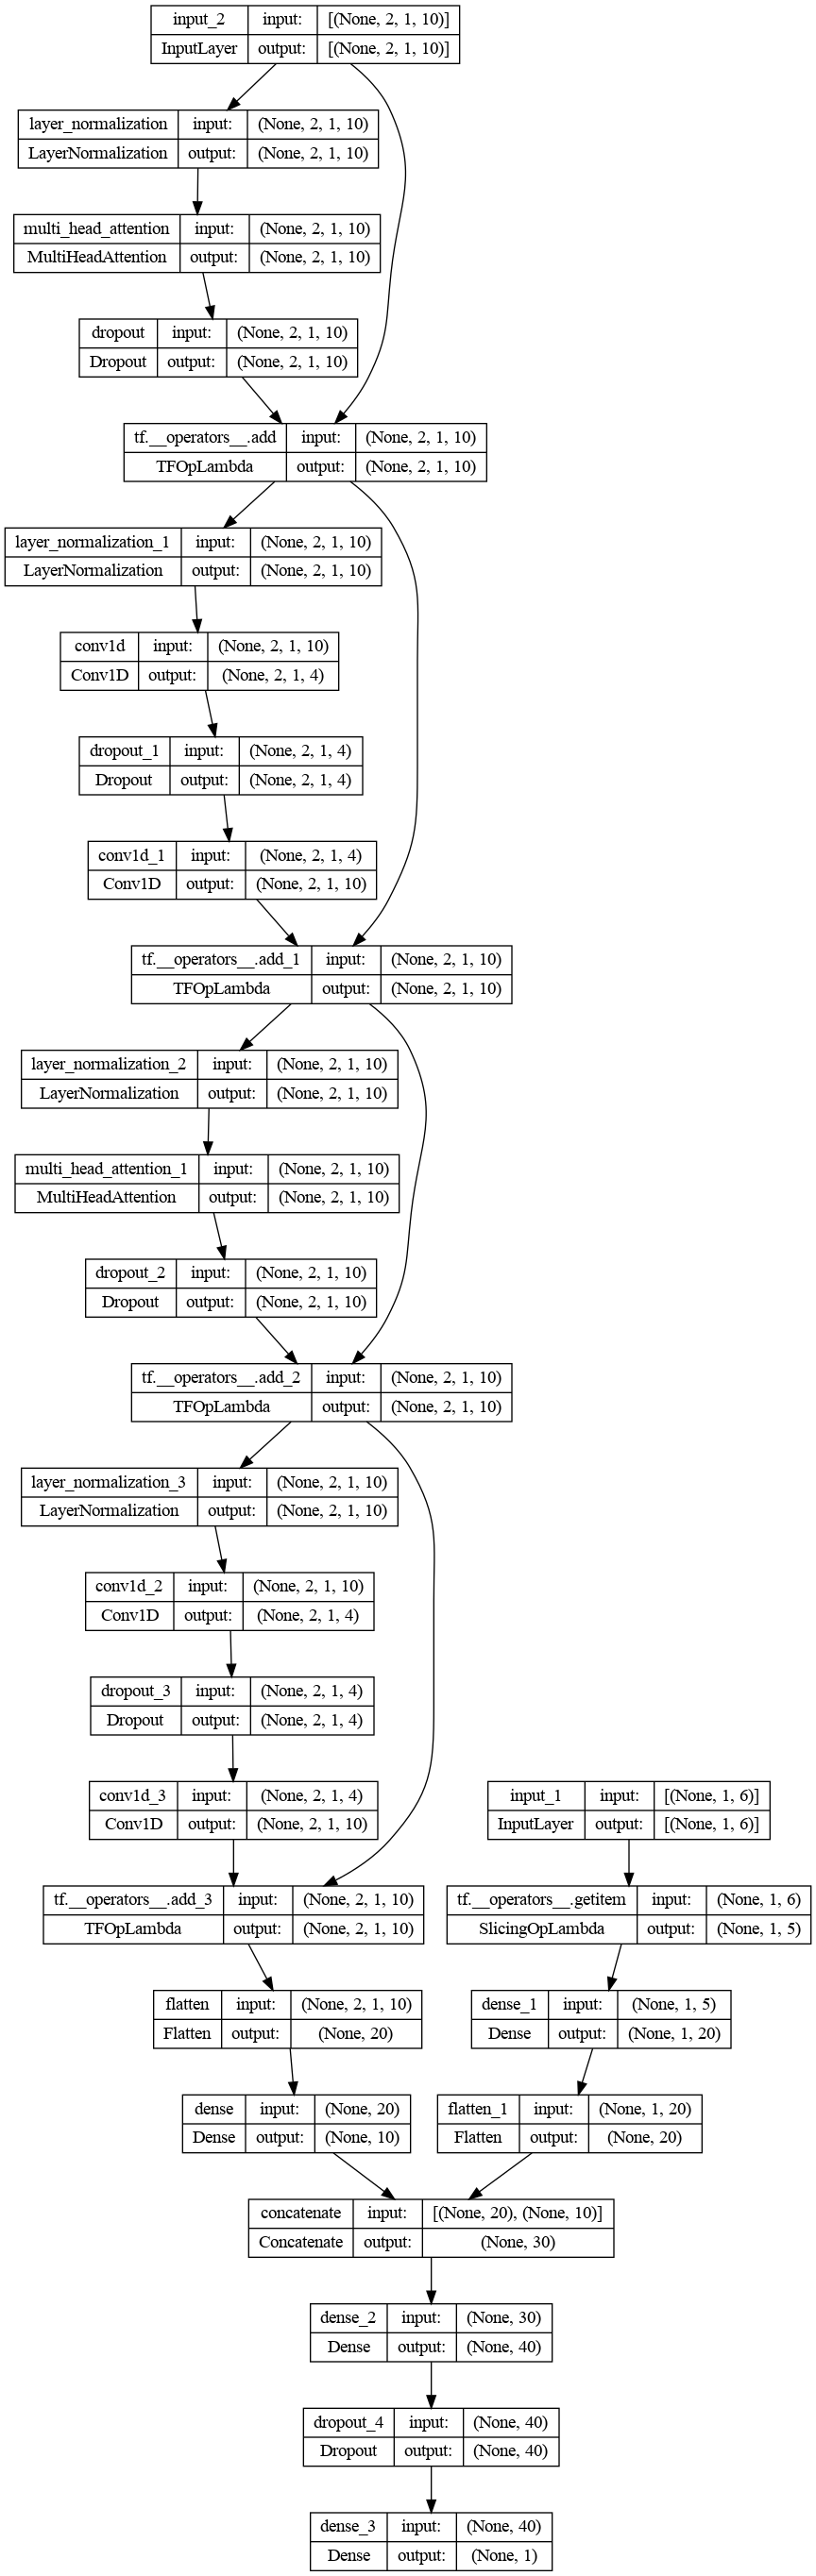

In [11]:
input_data_shape = x_data_p.shape[1:]
input_stockdata_shape = x_stockdata_p.shape[1:]
print(input_data_shape)
print(input_stockdata_shape)

model = build_model(
    [input_data_shape, input_stockdata_shape],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[40],
    mlp_dropout=0.1,
    dropout=0.1,
)

model.summary() 
tf.keras.utils.plot_model(model, to_file='thesis_model.png', show_shapes = True)

In [12]:
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    [x_data_p, x_stockdata_p],
    y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate([x_data_test,x_stockdata_test], y_test, verbose=1)

Epoch 1/500
899/899 [==============================] - 4s 3ms/step - loss: 180.9311 - val_loss: 7.4725
Epoch 2/500
899/899 [==============================] - 3s 3ms/step - loss: 16.2631 - val_loss: 4.0994
Epoch 3/500
899/899 [==============================] - 2s 3ms/step - loss: 6.2520 - val_loss: 3.3898
Epoch 4/500
899/899 [==============================] - 2s 3ms/step - loss: 5.2676 - val_loss: 2.9722
Epoch 5/500
899/899 [==============================] - 2s 3ms/step - loss: 4.6910 - val_loss: 2.7027
Epoch 6/500
899/899 [==============================] - 2s 3ms/step - loss: 4.4681 - val_loss: 3.0264
Epoch 7/500
899/899 [==============================] - 2s 3ms/step - loss: 4.2520 - val_loss: 2.3981
Epoch 8/500
899/899 [==============================] - 2s 3ms/step - loss: 3.8867 - val_loss: 2.2759
Epoch 9/500
899/899 [==============================] - 3s 3ms/step - loss: 3.9027 - val_loss: 2.2268
Epoch 10/500
899/899 [==============================] - 3s 3ms/step - loss: 3.4832 - val

0.5435053706169128

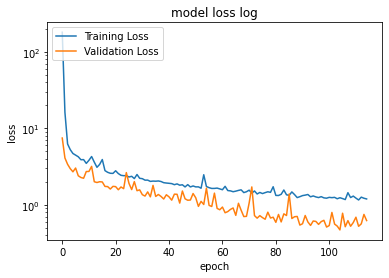

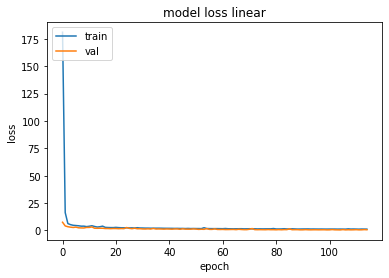

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.yscale("log")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss linear')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
from sklearn import metrics

pred = model.predict([x_data_test,x_stockdata_test])
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

562/562 [==============================] - 1s 2ms/step
Score (RMSE): 0.7372283099862801


In [15]:
print(np.mean(y_test))

8.22709348914858


In [17]:
import numpy as np
from sklearn import metrics

# Assuming 'pred' is your prediction and 'y_test' is the actual data.
# Ensure pred is a numpy array with shape (n_samples,) or (n_samples, 1) for consistency.
# If 'pred' has more than one column and you're interested in the first column, you can use pred[:,0].
# Otherwise, ensure both 'pred' and 'y_test' are 1-D arrays for these calculations.

# Calculate Mean Absolute Error (MAE)
mae_mean = metrics.mean_absolute_error(pred[:,0], y_test)
mae_median = np.median(np.abs(pred[:,0] - y_test))
mae_max = np.max(np.abs(pred[:,0] - y_test))

# Calculate Mean Absolute Percentage Error (MAPE)
mape_mean = np.mean(np.abs((pred[:,0] - y_test) / y_test) * 100)
mape_median = np.median(np.abs((pred[:,0] - y_test) / y_test) * 100)
mape_max = np.max(np.abs((pred[:,0] - y_test) / y_test) * 100)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(metrics.mean_squared_error(pred[:,0], y_test))

print(f"MAE: {mae_mean}")
print(f"Median AE: {mae_median}")
print(f"Max AE: {mae_max}")

print(f"MAPE: {mape_mean}%")
print(f"Median APE: {mape_median}%")
print(f"Median APE: {mape_max}%")

print(f"RMSE: {rmse}")

under10 = (np.sum(abs(((pred[:,0]-y_test)/y_test))*100 < 10) / (y_test).size) * 100
print("Below 10% AE: {}%".format(under10))


bids = y_train_up[:,0]
asks = y_train_up[:,1]

counter = 0
for index, prediction in enumerate(pred[:,0]):
    if prediction < asks[index] and prediction > bids[index]:
        counter += 1

btw_ba = counter/len(y_test)*100
print(btw_ba)

print(np.mean(asks-bids))

MAE: 0.42318080392146545
Median AE: 0.2757027626037596
Max AE: 17.868251419067384
MAPE: 9.754163532463554%
Median APE: 4.573358338454676%
Median APE: 389.69702659246747%
RMSE: 0.7372283099862801
Below 10% AE: 72.9827490261547%
3.717306622148024
0.7002793544796884


In [18]:
perc = np.mean(abs(((pred[:,0]-y_test)/y_test))*100)
print("Mean Percent Error: {}%".format(perc))
perc = np.median(abs(((pred[:,0]-y_test)/y_test))*100)
print("Median Percent Error: {}".format(perc))
perc = np.max(((pred[:,0]-y_test)/y_test)*100)
print("Max Percent Error: {}%".format(perc))
rms = np.max(np.sqrt(abs(pred[:,0]**2-y_test**2)))
print("Max Error (RMSE): {}".format(rms))
rms = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("RMSE: {}".format(rms))
max_err = np.max(abs(pred[:,0]-y_test))
argmax_err = np.argmax(abs(pred[:,0]-y_test))
print("Max Error: {} @ price = {}".format(max_err, y_test[argmax_err]))
under10 = (np.sum(abs(((pred[:,0]-y_test)/y_test))*100 < 10) / (y_test).size) * 100
print("Percentage below 10%: {}%".format(under10))

Mean Percent Error: 9.754163532463554%
Median Percent Error: 4.573358338454676
Max Percent Error: 389.69702659246747%
Max Error (RMSE): 25.67249221217678
RMSE: 0.7372283099862801
Max Error: 17.868251419067384 @ price = 27.35
Percentage below 10%: 72.9827490261547%


In [19]:
import numpy as np

# Assuming pred and y_test are your prediction and test arrays respectively
# Filter both arrays for cases where y_test is greater than 5 dollars
mask = y_test > 5
filtered_pred = pred[mask, 0]  # Assuming pred is a 2D array and you're interested in the first column
filtered_y_test = y_test[mask]

# Calculate the percent error for the filtered values
perc_error_filtered = np.max(np.abs((filtered_pred - filtered_y_test) / filtered_y_test) * 100)

print(f"Maximum percent error for stock prices above $5: {perc_error_filtered}%")


Maximum percent error for stock prices above $5: 68.08295962454258%


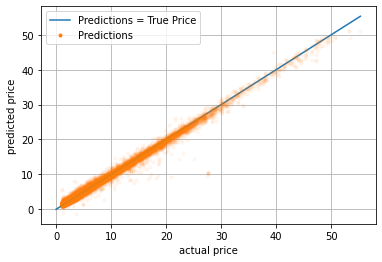

In [31]:
xs = np.linspace(0,max(y_test),20)

plt.plot(xs,xs)
plt.plot(y_test,pred[:,0],'.',alpha=0.05)
plt.xlabel("actual price")
plt.ylabel("predicted price")
legend = plt.legend(["Predictions = True Price", "Predictions"])
for handle in legend.legendHandles:
    handle.set_alpha(1)
plt.grid()
plt.show()

In [ ]:
xs = np.linspace(0,max(y_test),len(bids))

plt.plot(xs,np.zeros_like(xs))
plt.hist(y_test,pred[:,0]-y_test,'.',alpha=0.05)
plt.plot(xs,bids-y_test)
plt.plot(xs,asks-y_test)
plt.xlabel("actual bid")
plt.ylabel("predicted bid")
legend = plt.legend(["Predictions = True Price", "Predictions"])
for handle in legend.legendHandles:
    handle.set_alpha(1)
plt.grid()
plt.show()

Text(0, 0.5, 'Number of Predictions')

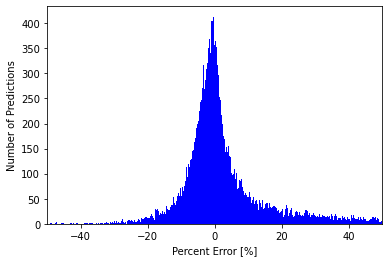

In [57]:
plt.hist(((pred[:,0]-y_test)/y_test)*100, bins=2000,color='blue')
plt.xlim(-50,50)
plt.xlabel("Percent Error [%]")
plt.ylabel("Number of Predictions")

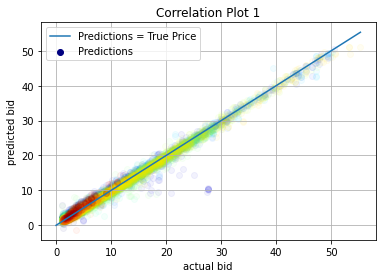

In [23]:
xs = np.linspace(0,max(y_test),20)

ticker_labels = ['CGC', 'CM', 'RY', 'BNS', 'BMO', 'BAM', 'SHOP', 'CP', 'CNI', 'MFC', 'TU', 'SLF', 'RCI']

# Colors for each ticker. Ensure there are as many colors as tickers.
colors = plt.cm.jet(np.linspace(0, 1, len(ticker_labels)))

# Convert the tensor for ticker indices to a NumPy array and adjust indices to be 0-based
ticker_indices = x_data_test[:, :, -1].numpy().astype(int).flatten() - 1

x_data = y_test
y_data = pred[:,0]

plt.plot(xs,xs)
        
for ticker_index, color in zip(range(len(ticker_labels)), colors):
    # Filter the data points for the current ticker
    current_x_data = x_data[ticker_indices == ticker_index]
    current_y_data = y_data[ticker_indices == ticker_index]
    # Plotting all points for the current ticker with the same color
    plt.scatter(current_x_data, current_y_data, alpha=0.05, color=color)

plt.title("Correlation Plot 1")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
legend = plt.legend(ticker_labels, loc='upper right', fontsize='small')  # Add a legend with a suitable font size
for legend_handle in legend.legendHandles: 
    legend_handle.set_alpha(1)


plt.xlabel("actual bid")
plt.ylabel("predicted bid")
legend = plt.legend(["Predictions = True Price", "Predictions"])
for handle in legend.legendHandles:
    handle.set_alpha(1)
plt.grid()
plt.show()

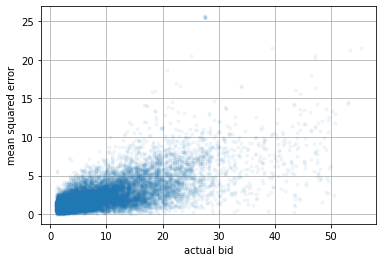

In [24]:
xs = np.linspace(0,max(y_test),20)

plt.plot(y_test,np.sqrt(abs(pred[:,0]**2-y_test**2)),'.',alpha=0.05)
plt.xlabel("actual bid")
plt.ylabel("mean squared error")
plt.grid()
plt.show()

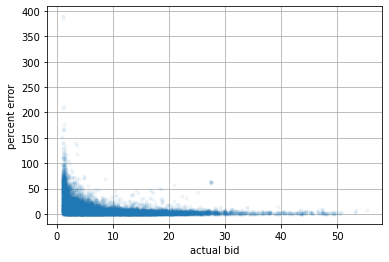

In [25]:
xs = np.linspace(0,max(y_test),20)

plt.plot(y_test,abs((pred[:,0]-y_test)/y_test)*100,'.',alpha=0.05)
plt.xlabel("actual bid")
plt.ylabel("percent error")
plt.grid()
plt.show()

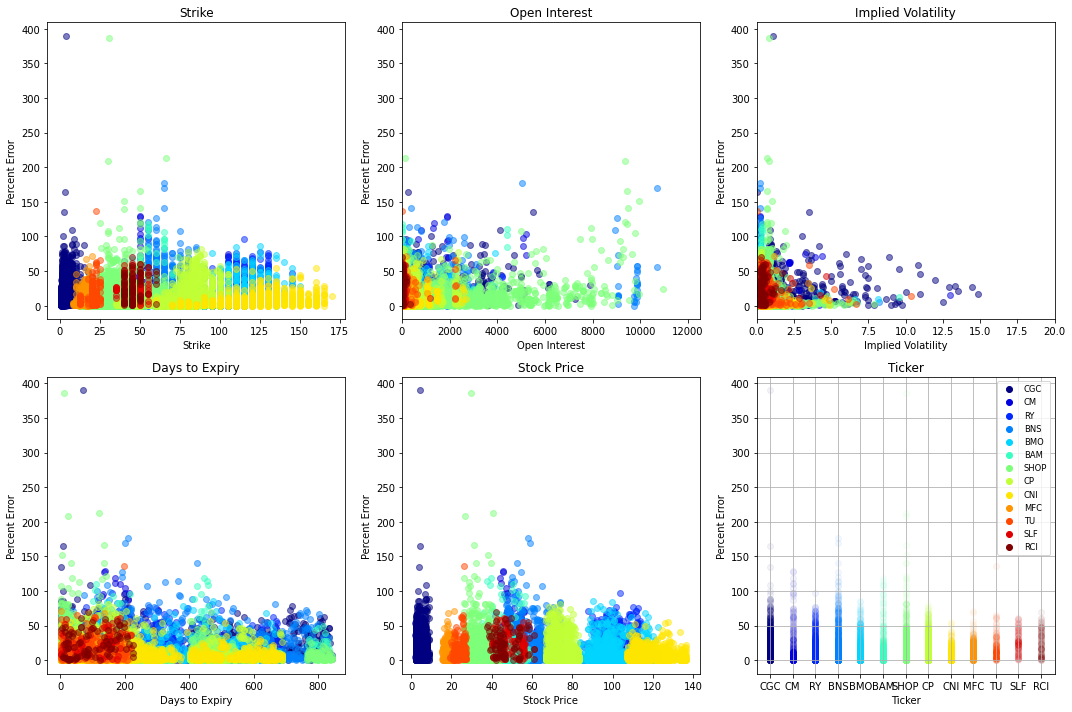

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming x_data_test, pred are defined elsewhere in your code as TensorFlow tensors
# y_test is a numpy array

# Titles for your plots
variables = ["Strike", "Open Interest", "Implied Volatility", "Days to Expiry", "Stock Price", "Ticker"]
n_vars = len(variables)  # Should be 6 as per your description
ticker_labels = ['CGC', 'CM', 'RY', 'BNS', 'BMO', 'BAM', 'SHOP', 'CP', 'CNI', 'MFC', 'TU', 'SLF', 'RCI']

# Colors for each ticker. Ensure there are as many colors as tickers.
colors = plt.cm.jet(np.linspace(0, 1, len(ticker_labels)))

# Set up the figure and axes for the subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier access

# Convert the tensor for ticker indices to a NumPy array and adjust indices to be 0-based
ticker_indices = x_data_test[:, :, -1].numpy().astype(int).flatten() - 1

for i in range(n_vars):  # Now include the last plot
    if i < n_vars - 1:  # For the first five plots
        # Convert tensors to NumPy arrays for plotting
        x_data = x_data_test[:, :, i].numpy()
        y_data = abs((pred[:, 0] - y_test) / y_test) * 100
        
        for ticker_index, color in zip(range(len(ticker_labels)), colors):
            # Filter the data points for the current ticker
            current_x_data = x_data[ticker_indices == ticker_index]
            current_y_data = y_data[ticker_indices == ticker_index]
            # Plotting all points for the current ticker with the same color
            axs[i].scatter(current_x_data, current_y_data, alpha=0.5, color=color)

        axs[i].set_title(variables[i])
        axs[i].set_xlabel("{}".format(variables[i]))
        axs[i].set_ylabel("Percent Error")
        # legend = axs[i].legend(ticker_labels, loc='upper right', fontsize='small')  # Add a legend with a suitable font size
        for legend_handle in legend.legendHandles: 
            legend_handle.set_alpha(1)

        # Specific x-axis limits for plots 2 and 3
        if i == 1:  # For the second plot (i.e., Open Interest)
            axs[i].set_xlim([0, 12500])
        elif i == 2:  # For the third plot (i.e., Implied Volatility)
            axs[i].set_xlim([0, 20])
            
    else:  # For the last plot (ticker plot)

        # Handling the last plot separately for the ticker labels
        i = 5  # Index for the last plot
        # Convert the tensor to a NumPy array and then to int, adjust indices to be 0-based
        ticker_indices = x_data_test[:, :, i].numpy().astype(int).flatten() - 1
        percent_errors = abs((pred[:, 0] - y_test) / y_test) * 100

        # Plot each point with its corresponding ticker label and color
        for ticker_index, color in zip(np.unique(ticker_indices), colors):
            # Filter the percent errors for the current ticker
            current_percent_errors = percent_errors[ticker_indices == ticker_index]
            # Plotting all points for the current ticker with the same color
            axs[i].scatter([ticker_labels[ticker_index]]*len(current_percent_errors),
                           current_percent_errors, alpha=0.05, label=ticker_labels[ticker_index],
                           color=color)

        axs[i].set_title(variables[i])
        axs[i].set_xlabel("Ticker")
        axs[i].set_ylabel("Percent Error")
        legend = axs[i].legend(loc='best', fontsize='small')  # Add a legend with a suitable font size
        for legend_handle in legend.legendHandles: 
            legend_handle.set_alpha(1)
        axs[i].grid()

        plt.tight_layout()  # Adjust subplots to fit into the figure area.
        plt.show()


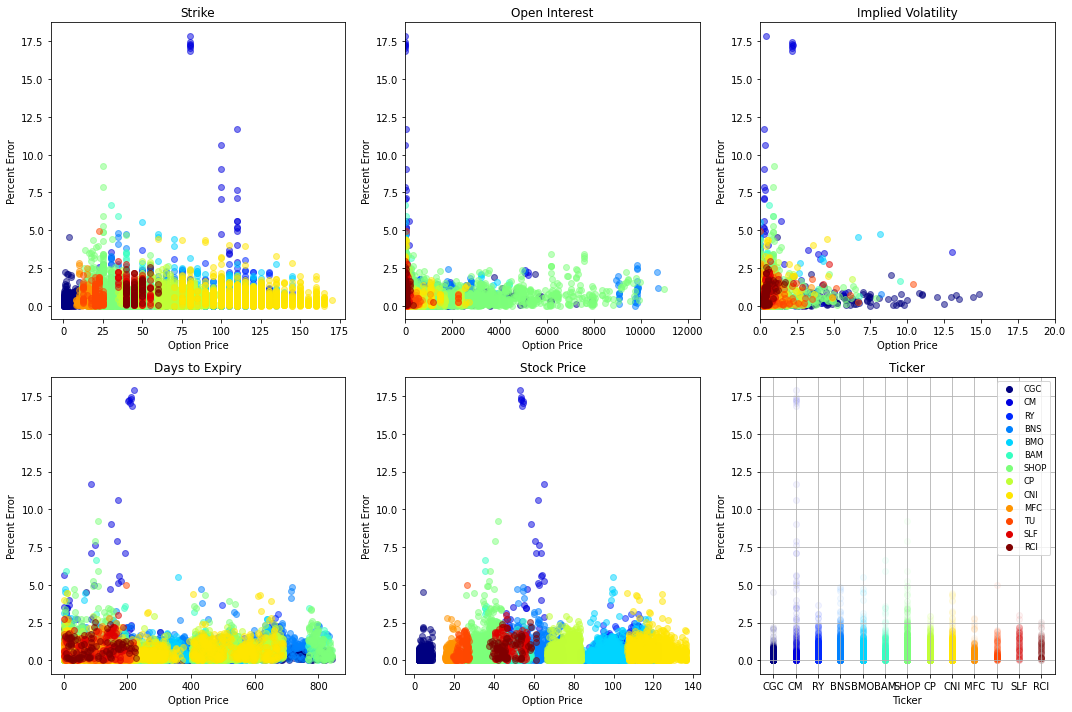

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Assuming x_data_test, pred are defined elsewhere in your code as TensorFlow tensors
# y_test is a numpy array

# Titles for your plots
variables = ["Strike", "Open Interest", "Implied Volatility", "Days to Expiry", "Stock Price", "Ticker"]
n_vars = len(variables)  # Should be 6 as per your description
ticker_labels = ['CGC', 'CM', 'RY', 'BNS', 'BMO', 'BAM', 'SHOP', 'CP', 'CNI', 'MFC', 'TU', 'SLF', 'RCI']

# Colors for each ticker. Ensure there are as many colors as tickers.
colors = plt.cm.jet(np.linspace(0, 1, len(ticker_labels)))

# Set up the figure and axes for the subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the size as needed
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easier access

# Convert the tensor for ticker indices to a NumPy array and adjust indices to be 0-based
ticker_indices = x_data_test[:, :, -1].numpy().astype(int).flatten() - 1

for i in range(n_vars):  # Now include the last plot
    if i < n_vars - 1:  # For the first five plots
        # Convert tensors to NumPy arrays for plotting
        x_data = x_data_test[:, :, i].numpy()
        y_data = abs(pred[:, 0] - y_test)
        
        for ticker_index, color in zip(range(len(ticker_labels)), colors):
            # Filter the data points for the current ticker
            current_x_data = x_data[ticker_indices == ticker_index]
            current_y_data = y_data[ticker_indices == ticker_index]
            # Plotting all points for the current ticker with the same color
            axs[i].scatter(current_x_data, current_y_data, alpha=0.5, color=color)

        axs[i].set_title(variables[i])
        axs[i].set_xlabel("Option Price")
        axs[i].set_ylabel("Percent Error")
        # legend = axs[i].legend(ticker_labels, loc='upper right', fontsize='small')  # Add a legend with a suitable font size
        for legend_handle in legend.legendHandles: 
            legend_handle.set_alpha(1)

        # Specific x-axis limits for plots 2 and 3
        if i == 1:  # For the second plot (i.e., Open Interest)
            axs[i].set_xlim([0, 12500])
        elif i == 2:  # For the third plot (i.e., Implied Volatility)
            axs[i].set_xlim([0, 20])
            
    else:  # For the last plot (ticker plot)

        # Handling the last plot separately for the ticker labels
        i = 5  # Index for the last plot
        # Convert the tensor to a NumPy array and then to int, adjust indices to be 0-based
        ticker_indices = x_data_test[:, :, i].numpy().astype(int).flatten() - 1
        percent_errors = abs(pred[:, 0] - y_test)

        # Plot each point with its corresponding ticker label and color
        for ticker_index, color in zip(np.unique(ticker_indices), colors):
            # Filter the percent errors for the current ticker
            current_percent_errors = percent_errors[ticker_indices == ticker_index]
            # Plotting all points for the current ticker with the same color
            axs[i].scatter([ticker_labels[ticker_index]]*len(current_percent_errors),
                           current_percent_errors, alpha=0.05, label=ticker_labels[ticker_index],
                           color=color)

        axs[i].set_title(variables[i])
        axs[i].set_xlabel("Ticker")
        axs[i].set_ylabel("Percent Error")
        legend = axs[i].legend(loc='best', fontsize='small')  # Add a legend with a suitable font size
        for legend_handle in legend.legendHandles: 
            legend_handle.set_alpha(1)
        axs[i].grid()

        plt.tight_layout()  # Adjust subplots to fit into the figure area.
        plt.show()


(array([1.296e+04, 9.294e+03, 6.829e+03, 5.333e+03, 4.628e+03, 3.820e+03,
        3.506e+03, 3.189e+03, 2.696e+03, 2.438e+03, 2.140e+03, 2.054e+03,
        1.614e+03, 1.597e+03, 1.353e+03, 1.055e+03, 1.127e+03, 8.780e+02,
        7.810e+02, 6.330e+02, 6.460e+02, 5.030e+02, 4.430e+02, 3.410e+02,
        2.650e+02, 2.260e+02, 1.720e+02, 1.490e+02, 1.170e+02, 1.080e+02,
        1.000e+02, 9.300e+01, 6.700e+01, 7.800e+01, 6.800e+01, 7.200e+01,
        6.800e+01, 5.500e+01, 5.200e+01, 7.500e+01, 4.400e+01, 5.000e+01,
        5.600e+01, 4.700e+01, 3.100e+01, 1.000e+01, 1.000e+00, 2.000e+00,
        1.400e+01, 2.000e+00]),
 array([ 1.025 ,  2.1105,  3.196 ,  4.2815,  5.367 ,  6.4525,  7.538 ,
         8.6235,  9.709 , 10.7945, 11.88  , 12.9655, 14.051 , 15.1365,
        16.222 , 17.3075, 18.393 , 19.4785, 20.564 , 21.6495, 22.735 ,
        23.8205, 24.906 , 25.9915, 27.077 , 28.1625, 29.248 , 30.3335,
        31.419 , 32.5045, 33.59  , 34.6755, 35.761 , 36.8465, 37.932 ,
        39.0175, 40.1

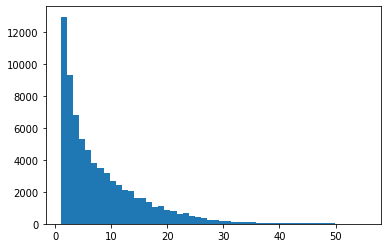

In [241]:
plt.hist(y_train, bins=50)

[[   5.]
 [1047.]
 [4884.]
 ...
 [ 439.]
 [  57.]
 [ 150.]]


(array([1.2607e+04, 2.2430e+03, 1.1490e+03, 4.8500e+02, 4.1500e+02,
        2.5300e+02, 1.5500e+02, 9.8000e+01, 1.1200e+02, 8.4000e+01,
        8.0000e+01, 4.4000e+01, 4.4000e+01, 2.8000e+01, 1.5000e+01,
        3.1000e+01, 1.7000e+01, 1.8000e+01, 1.4000e+01, 1.6000e+01,
        3.0000e+00, 5.0000e+00, 1.3000e+01, 3.0000e+00, 1.4000e+01,
        3.0000e+00, 5.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 6.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

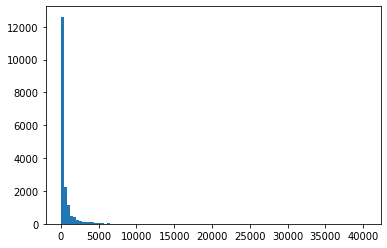

In [255]:
a = np.array(x_data_test[:,:,1])
print(a)
plt.hist(a, bins=100)

In [33]:
print(x_stockdata_p)

tf.Tensor(
[[[[0.1370616  0.14693004 0.20833327 ... 1.         0.83442961
    0.74780712]]

  [[0.13196481 0.12903226 0.19941349 ... 1.         0.82404692
    0.73900293]]]


 [[[0.83783798 1.         0.66666674 ... 0.32432426 0.19819824
    0.        ]]

  [[0.86111111 1.         0.6712963  ... 0.31944444 0.19444444
    0.        ]]]


 [[[0.95439759 0.62214985 0.39087977 ... 0.02931601 0.12377824
    0.        ]]

  [[0.57692308 0.28846154 0.26923077 ... 0.         0.02884615
    0.17307692]]]


 ...


 [[[0.82427772 1.         0.74335228 ... 0.21849719 0.07630017
    0.        ]]

  [[0.76331361 1.         0.76331361 ... 0.18343195 0.07692308
    0.        ]]]


 [[[0.28571439 0.34022548 0.26879707 ... 0.39473694 0.93421081
    1.        ]]

  [[0.30232558 0.36434109 0.30232558 ... 0.35658915 0.94573643
    1.        ]]]


 [[[0.49710976 0.         0.35549153 ... 1.         0.91233143
    0.89210031]]

  [[0.43939394 0.         0.21212121 ... 1.         0.83333333
    0.75757576]]]]

(array([4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([9.33594414e-01, 5.66149225e+01, 1.12296251e+02, 1.67977579e+02,
        2.23658907e+02, 2.79340235e+02, 3.35021563e+02, 3.90702891e+02,
        4.46384219e+02, 5.02065547e+02, 5.57746876e+02, 6.13428204e+02,
        6.69109532e+02, 7.24790860e+02, 7.80472188e+02, 8.36153516e+02,
        8.91834844e+02, 9.47516172e+02, 1.00319750e+03, 1.05887883e+03,
        1.11456016e+03, 1.17024148e+03, 1.22592281e+03, 1.28160414e+03,
        1.33728547e+03, 1.39296680e+03, 1.44864813e+03, 1.50432945e+03,
        1.56001078e+03, 1.61569211e+03, 1.67137344e+03, 1.72705477e+03,
        1.78273609e+03, 1.83841742e+03, 1.89409875e+03, 1.94978008e+03,
        2.00546141e+03, 2.06114273e+03, 2.11682406e+03, 2.17250539e+03,
        2.22818672e+03, 2.28386805e+03, 2.33954938e+03

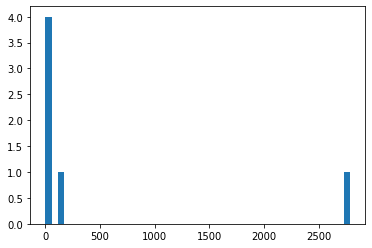

In [34]:
plt.hist(x_data_p[0,:], bins=50)

In [35]:
test_tickers = ['TD']

[x_data_up_t, x_stockdata_up_t, y_train_up_t] = produceXYDataSets(test_tickers, "C", stockdata_len)


Loading:
TD
0


In [36]:
y_test_t = (y_train_up_t[:,0]+y_train_up_t[:,1])/2

# x_data_p_t = (x_data_up_t - np.min(x_data_up)) / (np.max(x_data_up) - np.min(x_data_up))

x_data_p_t = tf.expand_dims(x_data_up_t, axis=1)
x_stockdata_p_t = tf.expand_dims(x_stockdata_up_t, axis=2)

print(x_data_p_t.shape, x_stockdata_p_t.shape, y_test_t.shape) 

# (16446, 1, 2) (16446, 20, 1) (16446,)
# (4112, 1, 2) (4112, 20, 1) (4112,)

(10325, 1, 6) (10325, 2, 1, 10) (10325,)


In [37]:
pred_t = model.predict([x_data_p_t,x_stockdata_p_t])

rms = np.sqrt(metrics.mean_squared_error(pred_t, y_test_t))
print("RMSE: {}".format(rms))
perc = np.mean(abs(((pred_t[:,0]-y_test_t)/y_test_t))*100)
print("Mean Percent Error: {}%".format(perc))
perc = np.median(abs(((pred_t[:,0]-y_test_t)/y_test_t))*100)
print("Median Percent Error: {}".format(perc))
rms = np.max(np.sqrt(abs(pred_t[:,0]**2-y_test_t**2)))
print("Max Error: {}".format(rms))
perc = np.max(((pred_t[:,0]-y_test_t)/y_test_t)*100)
print("Max Percent Error: {}%".format(perc))
under10 = (np.sum(abs(((pred_t[:,0]-y_test_t)/y_test_t))*100 < 10) / (y_test_t).size) * 100
print("Percentage below 10%: {}%".format(under10))


323/323 [==============================] - 1s 2ms/step
RMSE: 0.854582091094608
Mean Percent Error: 17.489426125282428%
Median Percent Error: 6.754528108190318
Max Error: 17.143081381648177
Max Percent Error: 168.66912841796872%
Percentage below 10%: 58.95399515738499%


In [40]:
pred_t = model.predict([x_data_p_t,x_stockdata_p_t])

perc = np.mean(abs(((pred_t[:,0]-y_test_t)/y_test_t))*100)
print("Mean Percent Error: {}%".format(perc))
perc = np.median(abs(((pred_t[:,0]-y_test_t)/y_test_t))*100)
print("Median Percent Error: {}".format(perc))
perc = np.max(((pred_t[:,0]-y_test_t)/y_test_t)*100)
print("Max Percent Error: {}%".format(perc))
rms = np.max(np.sqrt(abs(pred_t[:,0]**2-y_test_t**2)))
print("Max Error (RMSE): {}".format(rms))
rms = np.sqrt(metrics.mean_squared_error(pred_t,y_test_t))
print("RMSE: {}".format(rms))
max_err = np.max(abs(pred_t[:,0]-y_test_t))
print("Max Error: {}".format(max_err))
under10 = (np.sum(abs(((pred_t[:,0]-y_test_t)/y_test_t))*100 < 10) / (y_test_t).size) * 100
print("Percentage below 10%: {}%".format(under10))

323/323 [==============================] - 1s 2ms/step
Mean Percent Error: 17.489426125282428%
Median Percent Error: 6.754528108190318
Max Percent Error: 168.66912841796872%
Max Error (RMSE): 17.143081381648177
RMSE: 0.854582091094608
Max Error: 4.565227127075197
Percentage below 10%: 58.95399515738499%


In [41]:
import numpy as np
from sklearn import metrics

# Assuming 'pred' is your prediction and 'y_test' is the actual data.
# Ensure pred is a numpy array with shape (n_samples,) or (n_samples, 1) for consistency.
# If 'pred' has more than one column and you're interested in the first column, you can use pred[:,0].
# Otherwise, ensure both 'pred' and 'y_test' are 1-D arrays for these calculations.

# Calculate Mean Absolute Error (MAE)
mae_mean = metrics.mean_absolute_error(pred_t[:,0], y_test_t)
mae_median = np.median(np.abs(pred_t[:,0] - y_test_t))
mae_max = np.max(np.abs(pred_t[:,0] - y_test_t))

# Calculate Mean Absolute Percentage Error (MAPE)
mape_mean = np.mean(np.abs((pred_t[:,0] - y_test_t) / y_test_t) * 100)
mape_median = np.median(np.abs((pred_t[:,0] - y_test_t) / y_test_t) * 100)
mape_max = np.max(np.abs((pred_t[:,0] - y_test_t) / y_test_t) * 100)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(metrics.mean_squared_error(pred_t[:,0], y_test_t))

print(f"MAE: {mae_mean}")
print(f"Median AE: {mae_median}")
print(f"Max AE: {mae_max}")

print(f"MAPE: {mape_mean}%")
print(f"Median APE: {mape_median}%")
print(f"Median APE: {mape_max}%")

print(f"RMSE: {rmse}")

under10 = (np.sum(abs(((pred_t[:,0]-y_test_t)/y_test_t))*100 < 10) / (y_test_t).size) * 100
print("Below 10% AE: {}%".format(under10))


bids = y_train_up[:,0]
asks = y_train_up[:,1]

counter = 0
for index, prediction in enumerate(pred_t[:,0]):
    if prediction < asks[index] and prediction > bids[index]:
        counter += 1

btw_ba = counter/len(y_test_t)*100
print(btw_ba)

print(np.mean(asks-bids))

MAE: 0.6407043044849977
Median AE: 0.49527244567871165
Max AE: 4.565227127075197
MAPE: 17.489426125282428%
Median APE: 6.754528108190318%
Median APE: 168.66912841796872%
RMSE: 0.854582091094608
Below 10% AE: 58.95399515738499%
1.685230024213075
0.7002793544796884


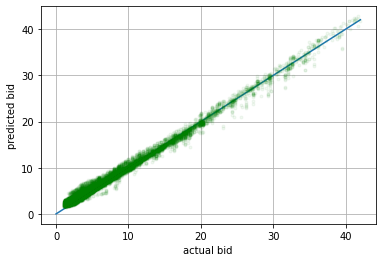

In [39]:
xs = np.linspace(0,max(y_test_t),20)

plt.plot(xs,xs)
plt.plot(y_test_t,pred_t[:,0],'.',alpha=0.05, color="green")
plt.xlabel("actual bid")
plt.ylabel("predicted bid")
plt.grid()
plt.show()

In [95]:
print(x_data_p.shape)
print(x_stockdata_p.shape)

(71880, 1, 6)
(71880, 2, 1, 10)


In [96]:
todays_data = np.array([[[60, 2, 0.4304, 291, 60.38, 2]]])
todays_stock = [[60.05,60.06,59.26,59.54,60.13,60.19,59.71,59.60,59.63,60.64]]
todays_option = [[0,0,0,4.8,4.8,4.8,4.8,4.8,4.8,4.8]]

todays_stock = (todays_stock - np.min(todays_stock)) / (np.max(todays_stock) - np.min(todays_stock))
todays_option = (todays_option - np.min(todays_option)) / (np.max(todays_option) - np.min(todays_option))

todays_seq = np.array([[todays_stock,todays_option]])

pred_today = model.predict([todays_data,todays_seq])

(1, 1, 6)
(1, 2, 1, 10)
1/1 [==============================] - 0s 447ms/step


In [97]:
print(pred_today)

[[8.637922]]


In [143]:
import time

model.predict([x_data_test,x_stockdata_test])

# Measure the prediction time
start_time = time.time()

# Make predictions
predictions = model.predict([x_data_test,x_stockdata_test])

# Measure the end time
end_time = time.time()

time_taken = end_time - start_time
print(f"Time taken for predicting {x_data_test.shape[0]} samples: {time_taken} seconds")

# Calculate the average time per sample
average_time_per_sample = time_taken / x_data_test.shape[0]
print(f"Average time per sample: {average_time_per_sample * 1000} milliseconds")

562/562 [==============================] - 4s 8ms/step
Time taken for predicting 17970 samples: 4.623063802719116 seconds
Average time per sample: 0.25726565401887125 milliseconds
